# Computer Vision Project
#### Introduction to Machine learning course | Instructor: Dr. Fatemeh Mirsalehi

<font color='cyan'> Responsible TA: Amirhossein Razlighi </font>

In [1]:
%pip install torch torchvision numpy matplotlib Pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Section 1: Implementing a CNN from scratch! (30 points)

### 1.1 - Forward and Backward (20/30 pts)

__CNN__ s are powerfull tools to work with in the scope of _Computer Vision_. You have seen MLPs before and know how to do forward and backward pass on them. In this part, we want to create a convolutional layer (a simple one, of course!) just to understand well that how a Convolutional Layer works, behind the scenes. Then, we can simply use PyTorch's `Conv2D` layer for the rest of this project, because we understood that how Convolutions work, behind the scene!

__FORWARD PASS__:

In forward pass, you should apply the convolution operation on the input image. The convolution operation is as follows:

$$
\text{output}[i, j] = \sum_{k=0}^{K-1} \sum_{l=0}^{L-1} \text{input}[i+k, j+l] \times \text{kernel}[k, l]
$$

You can see a sample convolution operation (with a $3 \times 3$ kernel) in the following image:
<div style="text-align:center;">
  <img src="./Images/Conv.gif" />
</div>

Please note that, these are samples for you to understand the operation better. For _forward pass_ that you should implement, please notice that you should convolve the kernel along all $C$ channels of the input image. So, the output shape should be $(N, H_{out}, W_{out})$. These values are calculated as follows:

$$
H_{out} = \frac{H_{in} + 2 \times \text{padding}}{\text{stride} - HH} + 1
$$
$$
W_{out} = \frac{W_{in} + 2 \times \text{padding}}{\text{stride} - WW} + 1
$$


where $HH$ and $WW$ are the height and width of the kernel, respectively. __stride__ is the step size of the kernel, and __padding__ is the number of zeros that should be padded to the input image. Please also note that $b$ stands for bias, which is a scalar value that should be added to the output of the convolution operation. (for each kernel)

You can see a more detailed example, below:

<div style="text-align:center;">
  <img src="./Images/conv3.gif" />
</div>

__Backward Pass__:

In backward pass, you should calculate gradient of output with respect to the input image and the kernel. These gradients will be used in _optimization_ to update kernel weights. (You saw something similar, in using MLPs with gradient descent algorithm!). So, we need $d_x$, $d_w$ and $d_b$ in the backward pass. These are calculated as follows:

$$
dx_{padded} [n, :, i * stride: i * stride + HH, j * stride: j * stride + WW] += w[f] \times dout[n, f, i, j]
$$

$$
dw_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1} x_{padded}[n, :, i * stride: i * stride + HH, j * stride: j * stride + WW] \times dout[n, f, i, j]  
$$

$$
db_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1} dout[n, f, i, j]
$$

For better understanding of the backward pass, you can see the following image:

<div style="text-align:center;">
  <img src="./Images/backprop_cs231n.png" />
</div>


In [3]:
import numpy as np

class MyConv:
    def __init__(self, stride, padding):
        self.stride = stride
        self.padding = padding

    def forward(self, x, w, b):
        N, C, H, W = x.shape  # Batch size, Channels, Height, Width
        F, _, HH, WW = w.shape  # Number of filters, Channels, Height, Width of filter

        pad = self.padding
        stride = self.stride
        H_out = (H + 2 * pad - HH) // stride + 1
        W_out = (W + 2 * pad - WW) // stride + 1

        x_pad = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant')
        out = np.zeros((N, F, H_out, W_out))

        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        out[n, f, i, j] = np.sum(
                            x_pad[n, :, i*stride:i*stride+HH, j*stride:j*stride+WW] * w[f, :, :, :]
                        ) + b[f]

        cache = (x, w, b, x_pad)
        self.cache = cache
        return out
    def backward(self, dout):
        x, w, b, x_padded = self.cache

        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        _, _, H_OUT, W_OUT = dout.shape

        dw = np.zeros_like(w)
        db = np.zeros_like(b)
        dx_padded = np.zeros_like(x_padded)

        for n in range(N):
            for f in range(F):
                for i in range(H_OUT):
                    for j in range(W_OUT):
                        dw[f] += x_padded[n, :, i*self.stride:i*self.stride+HH, j*self.stride:j*self.stride+WW] * dout[n, f, i, j]
                        dx_padded[n, :, i*self.stride:i*self.stride+HH, j*self.stride:j*self.stride+WW] += w[f] * dout[n, f, i, j]
                db[f] += np.sum(dout[n, f])

        if self.padding != 0:
            dx = dx_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dx = dx_padded

        self.dx = dx
        self.dw = dw
        self.db = db
        return dx, dw, db


In [4]:
def rel_error(x, y):
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
# A simple test for forward pass (DO NOT CHANGE)

x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

out = MyConv(stride=2, padding=1).forward(x, w, b)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# The outputted difference which is printed, should be around 1e-8
print ('Testing conv_forward_naive')
print ('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


In [6]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index

    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval

    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad

In [7]:
# A simple test for backward pass (DO NOT CHANGE)

x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(
    2,
)
dout = np.random.randn(4, 2, 5, 5)
conv = MyConv(stride=1, padding=1)

dx_num = eval_numerical_gradient_array(
    lambda x: conv.forward(x, w, b), x, dout
)
dw_num = eval_numerical_gradient_array(
    lambda w: conv.forward(x, w, b), w, dout
)
db_num = eval_numerical_gradient_array(
    lambda b: conv.forward(x, w, b), b, dout
)

out = conv.forward(x, w, b)
dx, dw, db = conv.backward(dout)

# Your printed errors should be around 1e-9
print("Testing conv_backward_naive function")
print("dx error: ", rel_error(dx, dx_num))
print("dw error: ", rel_error(dw, dw_num))
print("db error: ", rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  2.682973112870739e-08
dw error:  2.7461101341974777e-10
db error:  2.5371536983446715e-12


### 1.2 - Visualizing Convolution results (10/30 pts)

In this part, we try to visualize the results of the convolution operation. We will 2 sample photos (in `Images/Sample`) and then we will use our `MyConv` class to apply some cool convolutions (and see their result on an image).

In [8]:
from PIL import Image

first_img, second_img = Image.open("./Images/Sample/Sharif_1.JPG"), Image.open(
    "./Images/Sample/Sharif_2.jpg"
)
first_img = first_img.resize((256, 256))
second_img = second_img.resize((256, 256))

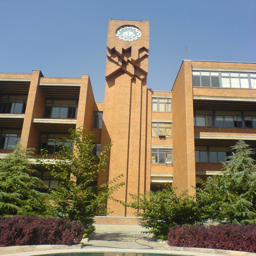

In [9]:
first_img

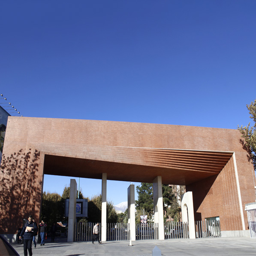

In [10]:
second_img

Convolutions have some interesting usages in image processing. For example, you can extract edges from an image by applying a convolution with a kernel that detects edges. Or you can convolve a specific kernel with your image to make it grayscale or blurred! Look at the definitions below:

__Edge Detection Kernel__:

_Sobel_ is one of the most famous edge detection kernels. It has two kernels, one for detecting vertical edges and the other for horizontal edges. You can see the kernels below:
$$
\text{Sobel}_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

$$
\text{Sobel}_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$


__Grayscale Kernel__:

You can simply convolve the image with the following kernel to make it grayscale:

$$
\text{Grayscale\_across\_R} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.3 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

$$
\text{Grayscale\_across\_G} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.6 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

$$
\text{Grayscale\_across\_B} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.1 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

(Convolve each kernel with its corresponding channel)

__Blurring Kernel__:

One of the famous kernels to blur an image is _Gaussian Blur_. You can see the kernel below:

$$
\text{Gaussian\_Blur} = \frac{1}{16} \times \begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$


In [11]:
# Sobel Kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

# Grayscale Kernels
grayscale_r = np.array([[0, 0, 0],
                        [0, 0.3, 0],
                        [0, 0, 0]])

grayscale_g = np.array([[0, 0, 0],
                        [0, 0.6, 0],
                        [0, 0, 0]])

grayscale_b = np.array([[0, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0]])

# Gaussian Blur Kernel
gaussian_blur = (1/16) * np.array([[1, 2, 1],
                                   [2, 4, 2],
                                   [1, 2, 1]])


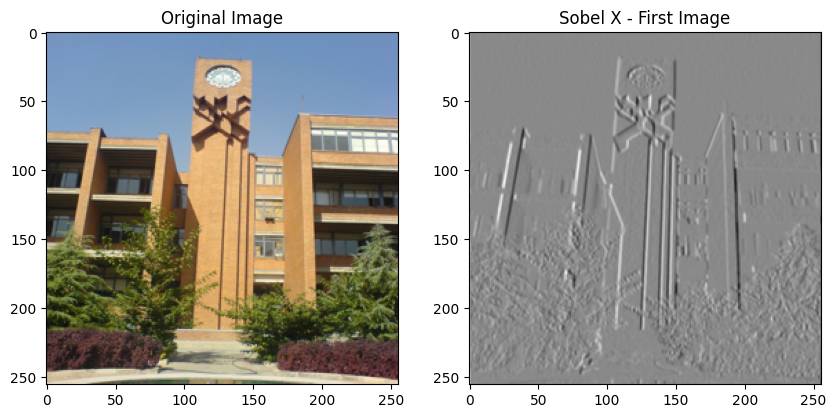

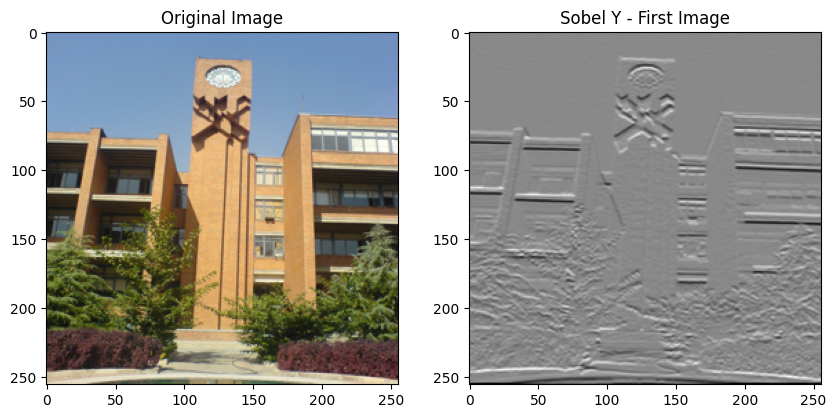

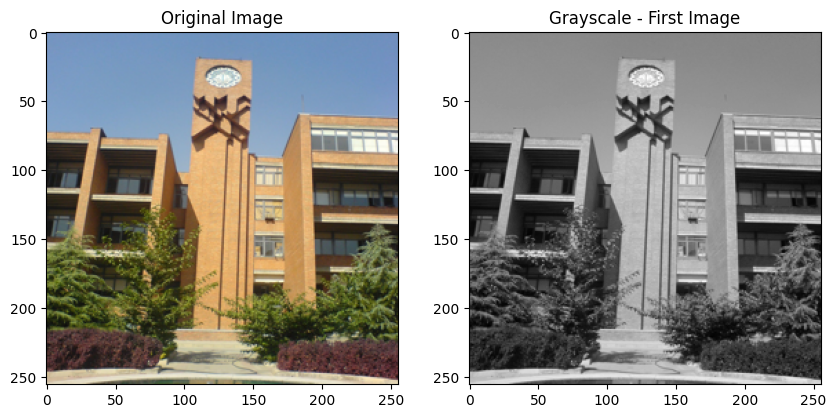

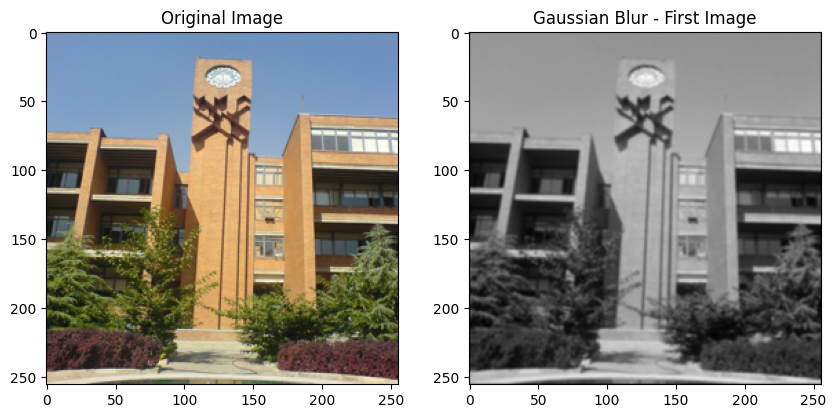

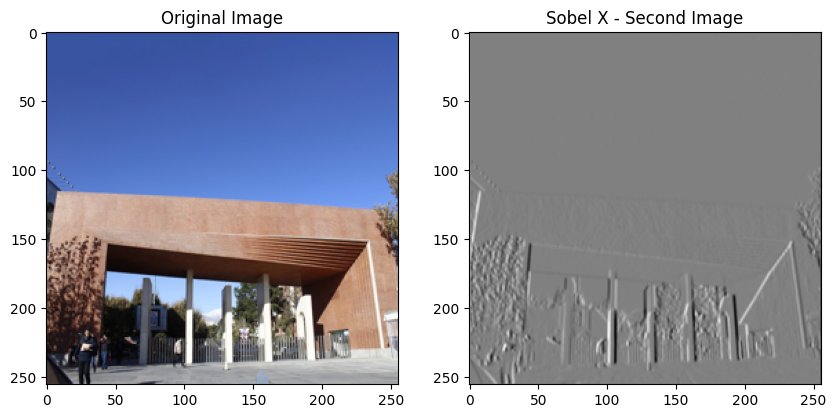

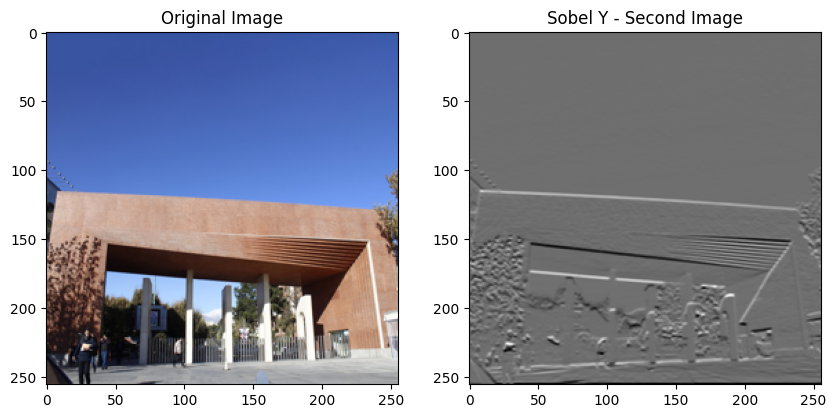

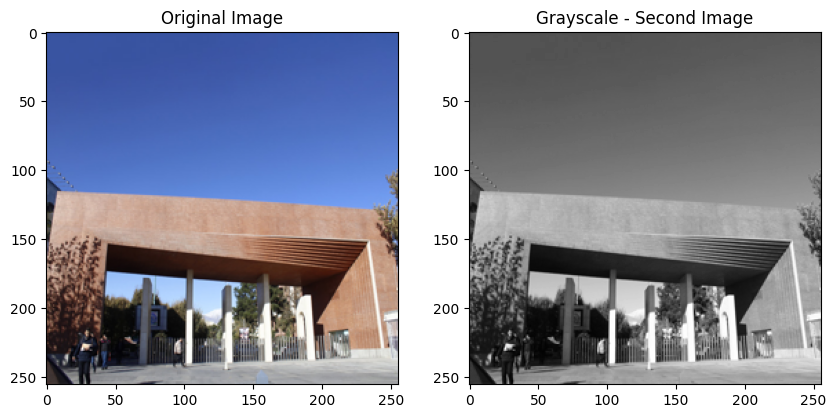

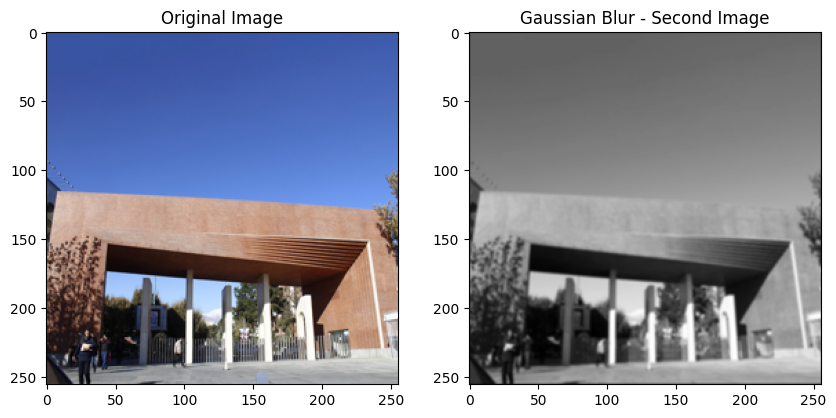

In [12]:
# Convert images to numpy arrays
img_size = 256
x = np.zeros((2, 3, img_size, img_size))
x[0] = np.array(first_img).transpose(2, 0, 1)
x[1] = np.array(second_img).transpose(2, 0, 1)

# Define convolution weights
w = np.zeros((4, 3, 3, 3))

# Assigning kernels to weights
w[0, 0, :, :] = sobel_x
w[1, 0, :, :] = sobel_y
w[2, 0, :, :] = grayscale_r
w[2, 1, :, :] = grayscale_g
w[2, 2, :, :] = grayscale_b
w[3, 0, :, :] = gaussian_blur
w[3, 1, :, :] = gaussian_blur
w[3, 2, :, :] = gaussian_blur

# Define biases
b = np.array([0, 0, 0, 0])

# Apply convolution
conv = MyConv(stride=1, padding=1)
out = conv.forward(x, w, b)

# Function to plot results
def plot_convolution_results(original, convolved, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(convolved, cmap='gray')
    plt.title(title)
    plt.show()

# Plotting results for the first image
plot_convolution_results(first_img, out[0, 0], 'Sobel X - First Image')
plot_convolution_results(first_img, out[0, 1], 'Sobel Y - First Image')
plot_convolution_results(first_img, out[0, 2], 'Grayscale - First Image')
plot_convolution_results(first_img, out[0, 3], 'Gaussian Blur - First Image')

# Plotting results for the second image
plot_convolution_results(second_img, out[1, 0], 'Sobel X - Second Image')
plot_convolution_results(second_img, out[1, 1], 'Sobel Y - Second Image')
plot_convolution_results(second_img, out[1, 2], 'Grayscale - Second Image')
plot_convolution_results(second_img, out[1, 3], 'Gaussian Blur - Second Image')


Now that we understood how Convolution works, we proceed further to use it in our models to perform a desired and specific task! We can use PyTorch's `Conv2D` layer from now on, because we understood how Convolutions work, behind the scene!

## Section 2: Neural Style Transfer (90 points)

In this part, we are going to implement a famous technique in the field of _Computer Vision_ called __Neural Style Transfer__. This technique is used to apply the style of a specific image to another image. For example, you can apply the style of a famous painting to your photo! Let's get started!

### 2.1 - Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy
import os

In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
torch.set_default_device(device)
device

device(type='cpu')

### 2.2 - Loading Images and doing some Preprocessing (5/90 pts)

In this part, you should load the content and style images and preprocess them. Preprocessing includes resizing the images to a specific size, normalizing them, and converting them to PyTorch tensors. You can use `torchvision.transforms` to do these tasks.

In [29]:
img_size = 512 if device != "cpu" else 256

preprocess = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

In [38]:
style_image = preprocess(Image.open('/content/Images/Neural_Transfer/style.jpeg'))
content_image = preprocess(Image.open('/content/Images/Neural_Transfer/Content.jpeg'))

style_image.size(), content_image.size()

(torch.Size([3, 512, 512]), torch.Size([3, 512, 512]))

Here, you should implement a helper function to show you images (which are now in form of pytorch tensors) in the notebook. You can use `torchvision.transforms.ToPILImage` to convert a tensor to a PIL image.

In [39]:
def imshow(tensor, title=None):
    plt.title(title)
    plt.imshow(transforms.ToPILImage()(tensor))
    plt.show()

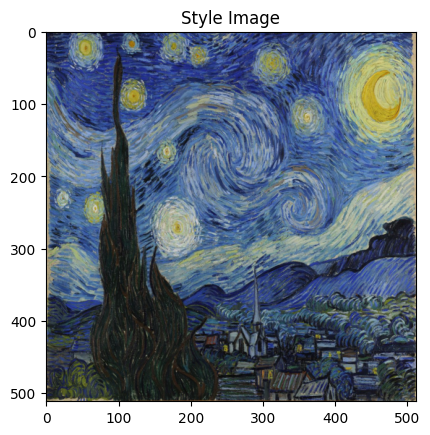

In [40]:
imshow(style_image, "Style Image")

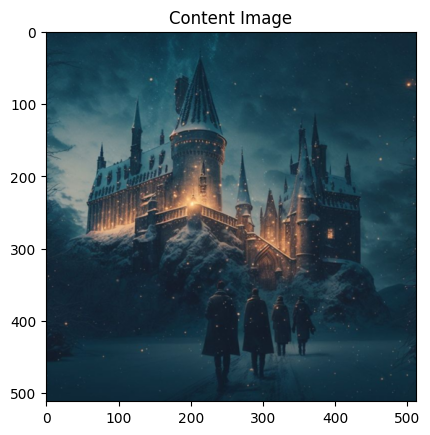

In [41]:
imshow(content_image, "Content Image")

### 2.2 - VGG19 Model (15/90 pts)

One of the important parts of Neural Style Transfer is to use a pre-trained model to extract features from the content and style images. Here, we are going to use a pre-trained VGG19 model to extract features from the images. You can use `torchvision.models.vgg19` to load the model. You should also freeze the weights of the model to prevent them from updating during the optimization process.

<div style="text-align:center;">
  <img src="./Images/VGG-19.png" />
</div>

But what is VGG model? Let's see with a simple experiment:

In [42]:
import certifi
import os

os.environ['SSL_CERT_FILE'] = certifi.where()

Here, please load `VGG19` model from `torchvision.models` and see the architecture of the model. You may need models `features` and `classifier` part stored seperately as we will discuss these both parts.

In [43]:
import torch
import torchvision.models as models

# Load the VGG19 model
vgg_model = models.vgg19(pretrained=True)

# Freeze the weights of the model
for param in vgg_model.parameters():
    param.requires_grad = False

# Separate the features and classifier parts
vgg_model_features = vgg_model.features
vgg_model_classifier = vgg_model.classifier

# Display the architecture of the model
print("VGG19 Features:")
print(vgg_model_features)

print("\nVGG19 Classifier:")
print(vgg_model_classifier)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG19 Features:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True

In [44]:
from torchsummary import summary

# Print the summary of the VGG19 model
summary(vgg_model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [45]:
from torchsummary import summary

# Print the summary of the VGG19 features part
print("VGG19 Features Summary:")
summary(vgg_model_features, (3, 224, 224))

# Print the summary of the VGG19 classifier part
print("\nVGG19 Classifier Summary:")
summary(vgg_model_classifier, (512*7*7,))  # Adjust input size for the classifier part


VGG19 Features Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             Re

Please briefly explain what is a VGG model used for and what does each `features` and `classifier` part, represent?

**Your Answer:**

The VGG model, short for Visual Geometry Group model, is a type of convolutional neural network (CNN) that was proposed by Simonyan and Zisserman in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition." The VGG models are renowned for their simple and highly effective architecture. Here's a brief explanation of what the VGG model is used for and what each part of the model represents:

What is a VGG Model Used For?
The VGG model is primarily used for image classification tasks. It was originally trained on the ImageNet dataset, which contains millions of images across a thousand categories. The model can be fine-tuned or used as a feature extractor for various computer vision tasks, including:

Image classification
Object detection
Image segmentation
Neural style transfer
Feature extraction for other machine learning models
Architecture of the VGG Model
The VGG model has a straightforward architecture that consists of several convolutional layers followed by fully connected layers. The depth of the network can vary (e.g., VGG16, VGG19, where the numbers denote the number of weight layers).

Features Part
The "features" part of the VGG model consists of a series of convolutional layers, max-pooling layers, and ReLU activation functions. These layers are responsible for:

Convolutional Layers: These layers apply convolutional filters to the input image to extract features such as edges, textures, and shapes. Each convolutional layer typically follows this pattern:

Convolution operation
ReLU activation function (introduces non-linearity)
Optional batch normalization
Max-Pooling Layers: These layers reduce the spatial dimensions (height and width) of the feature maps while retaining the most important information. This process helps in reducing the computational complexity and making the model more robust to variations in the input.

The features part captures different levels of abstraction in the input image. The earlier layers capture low-level features (e.g., edges, textures), while the deeper layers capture high-level features (e.g., object parts, shapes).

Classifier Part
The "classifier" part of the VGG model consists of fully connected layers and a softmax layer at the end. This part is responsible for:

Fully Connected Layers: These layers take the flattened output from the final max-pooling layer and process it through several dense layers. These layers learn to combine the extracted features to classify the input image into one of the predefined categories.

Softmax Layer: The final layer is usually a softmax layer that outputs a probability distribution over the target classes. The class with the highest probability is considered the predicted class.

The classifier part of the VGG model transforms the high-level features into a set of class probabilities, enabling the model to perform the final classification.

Summary of the VGG19 Model
Features Part: Extracts hierarchical features from the input image using convolutional layers and pooling layers.
Classifier Part: Uses fully connected layers to classify the extracted features into target categories.
This combination of feature extraction and classification makes the VGG model a powerful tool for a variety of computer vision tasks.








Now, we are going to give a sample image `Images/Neural_Transfer/Car.jpeg` to the model, see the output for classification and also visualize the feature maps (outputs of each convolutional layer) to see what's going on!

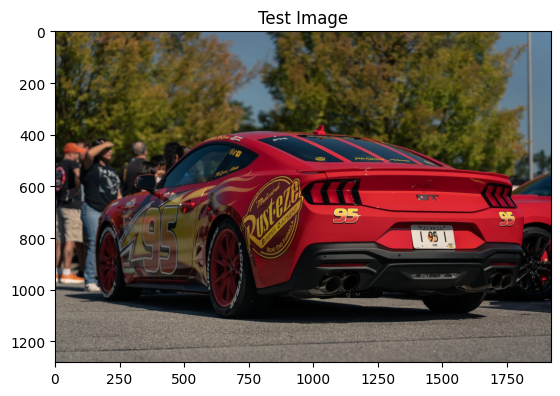

In [78]:
vgg_test_image = Image.open("./Images/Neural_Transfer/Car.jpeg")

plt.title('Test Image')
plt.imshow(vgg_test_image)

In [79]:
preprocess_vgg = preprocess(vgg_test_image)
outputs = []
vgg_model.eval()
for layer in vgg_model_features:
    preprocess_vgg = layer(preprocess_vgg)
    if isinstance(layer, torch.nn.Conv2d):
        outputs.append(preprocess_vgg)

preprocess_vgg = nn.AdaptiveAvgPool2d(output_size=(7, 7))(preprocess_vgg)
predicted = torch.max(vgg_model_classifier(preprocess_vgg.view(1, -1)), 1)[1]

In [73]:
print(f'predicted class: {predicted.item()}')

predicted class: 817


As you can see, the output of the classifier is an integer. This integer is actually the **class number** in _Image Net_ dataset. Let's get the name of the class:

In [74]:
import requests

class_idx = requests.get(
    "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
).json()

# Get the class name
class_name = class_idx[predicted.item()]

print(f"Predicted class: {class_name}")

Predicted class: sports car


Now that we understood the architecture of VGG, and also the output of its classifier, it's time to extract features from the images! And see what's going on in the feature maps!

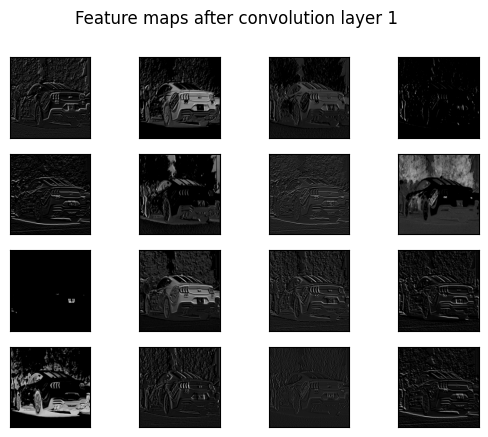

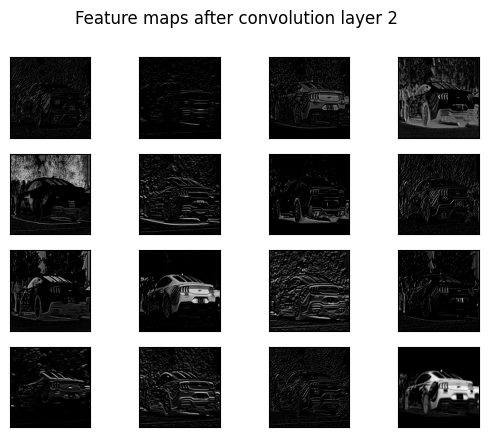

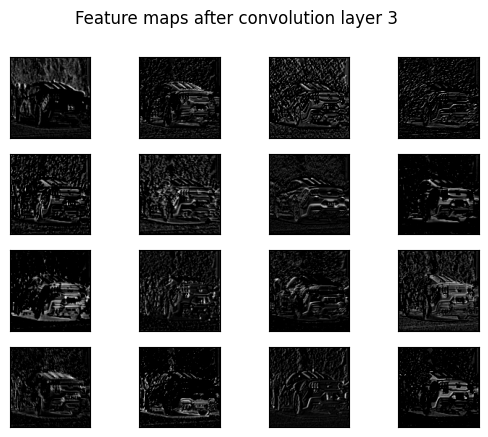

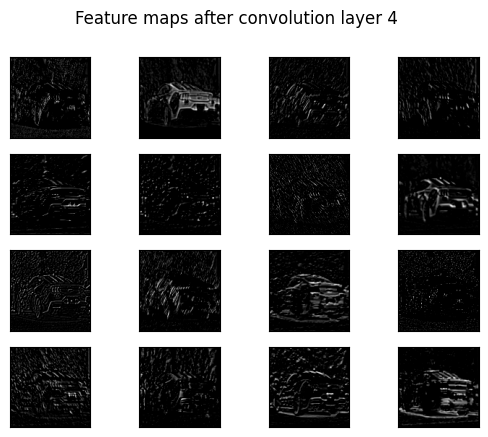

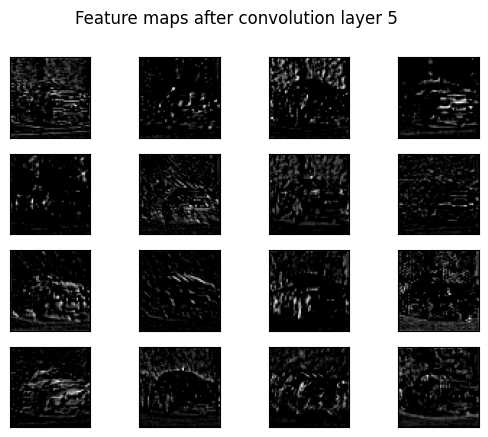

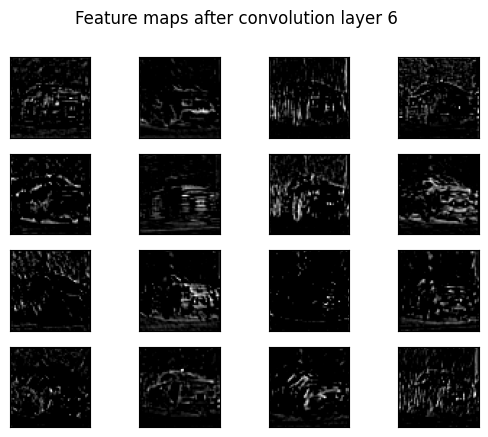

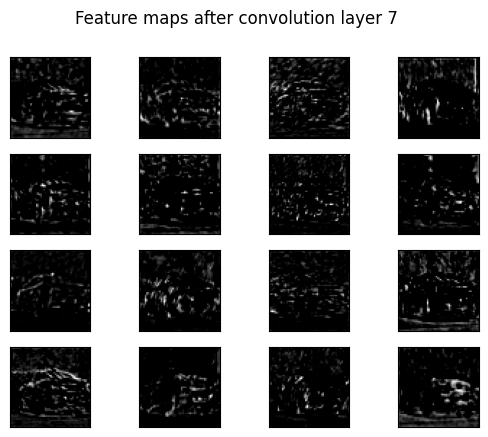

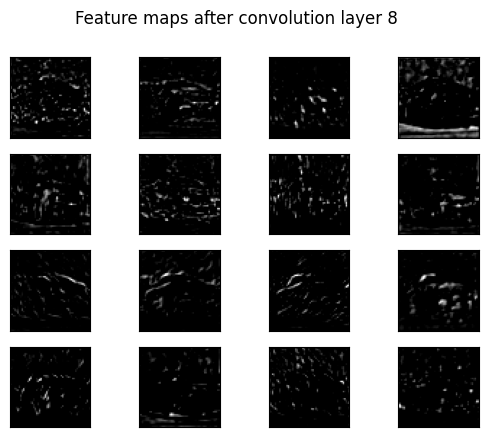

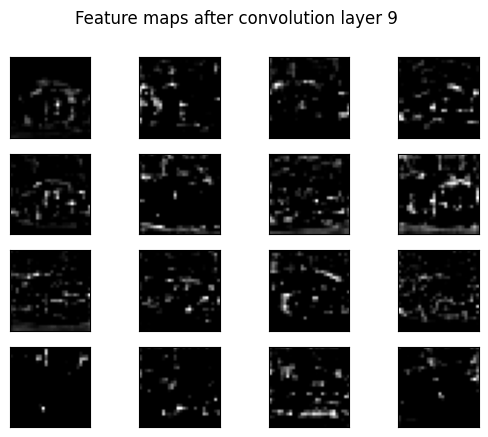

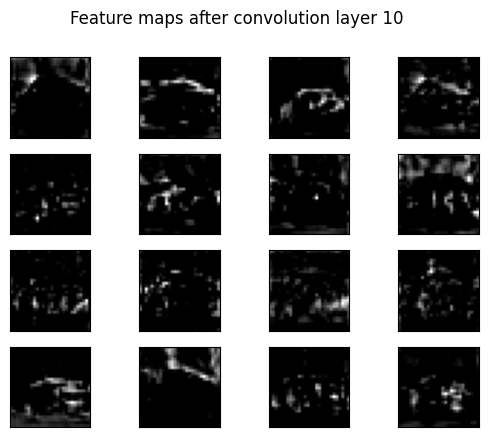

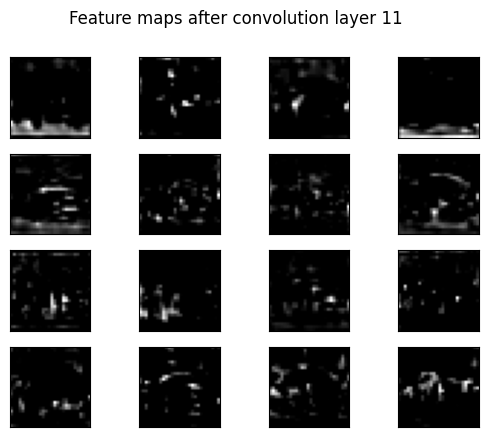

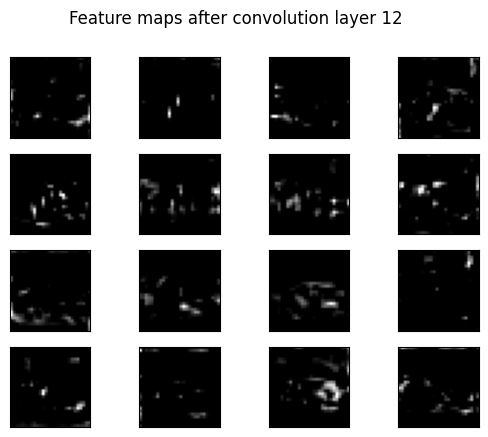

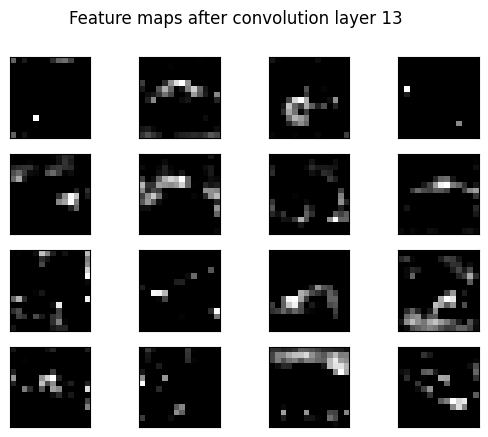

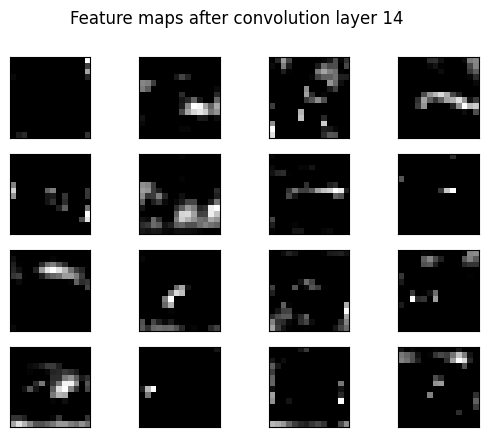

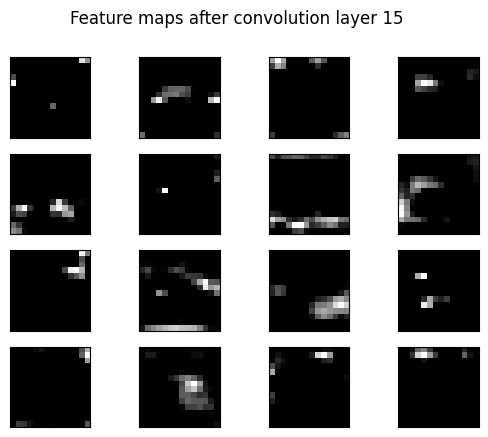

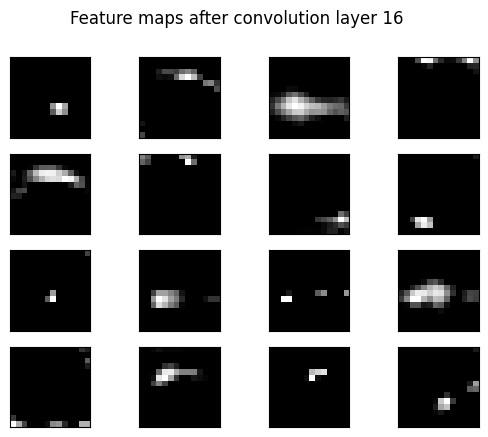

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def select_random_features(feature_set, quantity):
    selected_indices = []
    while len(selected_indices) < quantity:
        random_index = np.random.choice(feature_set.size(0))
        if random_index in selected_indices:
            continue
        selected_feature_maps = feature_set[random_index].detach().numpy()
        min_value = selected_feature_maps.min()
        max_value = selected_feature_maps.max()
        if np.abs(min_value - max_value) < 1:
            continue
        selected_indices.append(random_index)
    return selected_indices

for layer_index, feature_map in enumerate(feature_outputs):
    plt.suptitle(f'Feature maps after convolution layer {layer_index + 1}')
    for plot_index, selected_index in enumerate(select_random_features(feature_map, 16)):
        plt.subplot(4, 4, plot_index + 1)
        plt.xticks([])
        plt.yticks([])
        normalized_feature_map = feature_map[selected_index].detach().numpy()
        min_value = normalized_feature_map.min()
        max_value = normalized_feature_map.max()
        normalized_feature_map = (normalized_feature_map - min_value) / (max_value - min_value)
        plt.imshow(normalized_feature_map, cmap='gray')
    plt.show()


It's fun too look under the hood, isn't it? As you can see, we can guess what are the learned features in each layer if the network (at least in the first layers). For example, in the first layer, the network learns to detect edges, and in the second layer, it learns to detect simple shapes. In the deeper layers, the network learns to detect more complex features.

### 2.3 - Content and Style Loss (15/90 pts)

In order to learn the correct image and keep the content of the original image while applying the style of the seconf image, we need 2 losses: 1. Content Loss and 2. Style Loss. Let's delve into each one!

**Content Loss** is responsible for keeping the content of the original image. It is calculated as the mean squared error between the feature maps of the original image and the generated image.

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss_function = nn.MSELoss()

    def forward(self, input):
        self.loss = self.loss_function(input, self.target)
        return input

**Style Loss** is responsible for applying the style of the second image to the generated image. It is calculated as the mean squared error between the Gram matrices of the feature maps of the second image and the generated image.

In [118]:
def gram_calculator(input):
    """
    Calculate the normalized Gram Matrix of a given input.
    """
    _, b, c, d = input.size()
    features = input.view(b, c * d)
    G = torch.mm(features, features.t())
    return G.div(b * c * d)


In [117]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # Compute the target Gram matrix and detach it from the computation graph
        self.target = gram_calculator(target_feature).detach()
        self.loss_function = nn.MSELoss()

    def forward(self, input):
        # Compute the Gram matrix of the input
        G = gram_calculator(input)
        # Calculate the mean squared error between the target and input Gram matrices
        self.loss = self.loss_function(G, self.target)
        return input


Now, we use `features` part of the VGG model to extract features from the content and style images. Then, we calculate the content and style loss using the extracted features.

In [86]:
import torchvision.models as models

convolutional_net = vgg_model_features


In [87]:
cnn_normalization_mean = torch.tensor(
    [0.485, 0.456, 0.406]
)
cnn_normalization_std = torch.tensor(
    [0.229, 0.224, 0.225]
)
normalized_style_image = transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)(style_image).unsqueeze(0)
normalized_content_image = transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)(content_image).unsqueeze(0)

Please note that after which layers you should calculate the content loss and after which ones, you should calculate the style loss. Use the layer names you saw earlier in the `torchsummary` output for VGG19 model.

In [88]:
default_content_layers = [len(convolutional_net) - 1 - [layer._get_name() for layer in convolutional_net.children()][::-1].index('Conv2d')]
default_style_layers = [index for index in range(len(convolutional_net)) if convolutional_net[index]._get_name() == 'Conv2d']


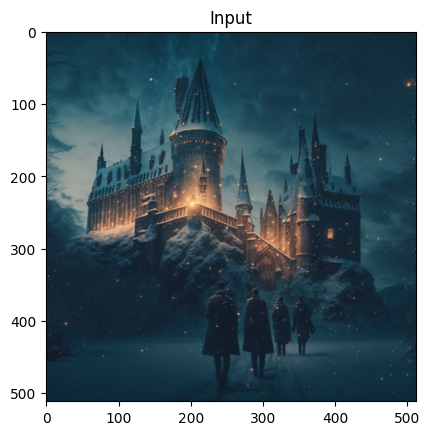

In [91]:
imshow(content_image, 'Input')

(15/90 pts) Now, we need to define our optimizer. We use `LBFGS` optimizer. Let's get familiar with this optimizer a little bit:

Let's use this optimizer to optimize a simple function $f(x) = x^2$. We want to find the minimum of this function using `LBFGS` optimizer. First, you should initialize a tensor $x$ with a random value. Then, you should define a closure function that calculates the value of the function and its gradient. Finally, you should use the `step` method of the optimizer to update the value of $x$.

And lastly, you should generate an animation using `matplotlib.animation` to show how the value of $x$ changes during optimization.

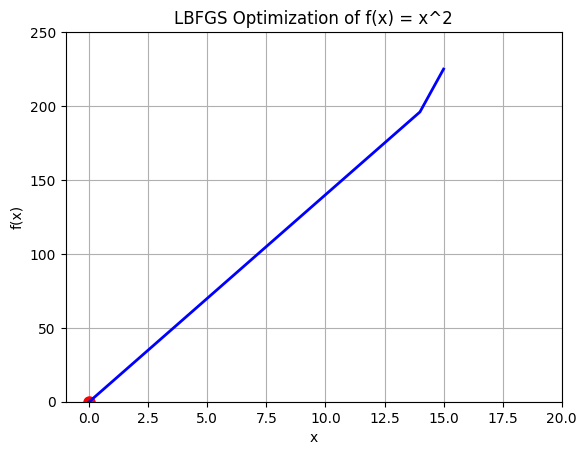

In [115]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.optim import LBFGS
from IPython.display import HTML

# Define the function
def squared(x):
    return x * x

# Initialize tensor with a random value
x = torch.tensor([15.0], requires_grad=True)

# Define the LBFGS optimizer
optimizer = LBFGS([x])

# Closure function
x_values = []

def closure():
    optimizer.zero_grad()
    y = squared(x)
    y.backward()
    x_values.append(x.item())
    return y

# Optimization loop
for step in range(10):
    optimizer.step(closure)

fig, ax = plt.subplots()
line, = ax.plot([], [], 'ro-', markersize=8)
path_line, = ax.plot([], [], 'b-', linewidth=2)
ax.set_xlim(-1, 20)
ax.set_ylim(0, 250)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('LBFGS Optimization of f(x) = x^2')
ax.grid()

def init():
    line.set_data([], [])
    path_line.set_data([], [])
    return line, path_line

def update(frame):
    line.set_data([x_values[frame]], [x_values[frame] ** 2])
    path_line.set_data(x_values[:frame + 1], [x ** 2 for x in x_values[:frame + 1]])
    return line, path_line

ani = animation.FuncAnimation(fig, update, frames=range(len(x_values)), init_func=init, blit=True, repeat=False)

# Display the animation inline
HTML(ani.to_jshtml())


(35/90 pts) Now, let's use this optimizer to optimize our `input_image` to minimize the content and style loss. You should define a closure function that calculates the content and style loss and their gradients. Then, you should use the `step` method of the optimizer to update the value of the `input_image`. Please also **note** that you should use a weighted sum of the content and style loss to optimize the input image. (weight of each loss is a hyperparameter)

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg19
import copy
import os


# Create the input image and make it require gradient
input_image = content_image.clone()
input_image.requires_grad_(True)

# Hyperparameters
style_weight = 1e6
content_weight = 1

# Define the optimizer
optimizer = LBFGS([input_image])

# Prepare the model
normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

content_losses = []
style_losses = []

model = nn.Sequential(normalization)

i = 0
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
        target = model(content_image).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        target_feature = model(style_image).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

# Remove layers after the last content and style loss
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break

model = model[:i + 1]

# Train the model using the LBFGS optimizer
run = [0]
while run[0] <= 300:

    def closure():
        input_image.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_image)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

            # Show the image
            unloader = transforms.ToPILImage()
            image = input_image.cpu().clone()
            image = image.squeeze(0)
            image = unloader(image)
            plt.imshow(image)
            plt.show()

        return style_score + content_score

    optimizer.step(closure)

# Finalize the image
input_image.data.clamp_(0, 1)


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


ValueError: not enough values to unpack (expected 4, got 3)

Now, let's see the result of optimization process on our `input_image`.

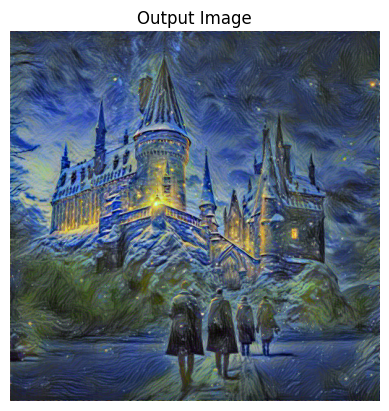

In [ ]:
# TODO: Plot the final image
...

(5/90 pts) Also, let's plot our `style_losses`, `content_losses` and `total_losses` to see how they change during the optimization process.

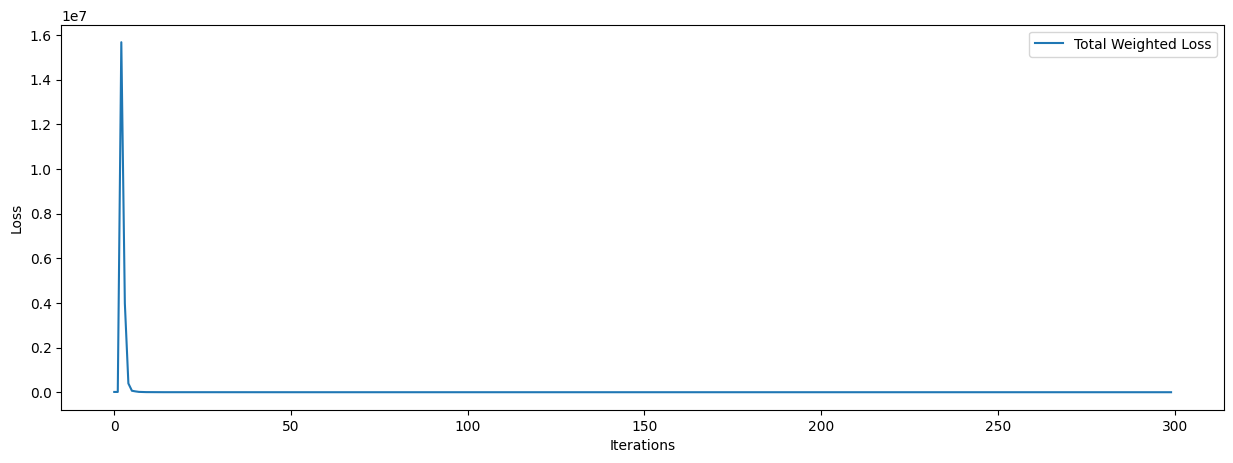

In [ ]:
#TODO: Plot the total weighted loss w.r.t. the iteration number
...

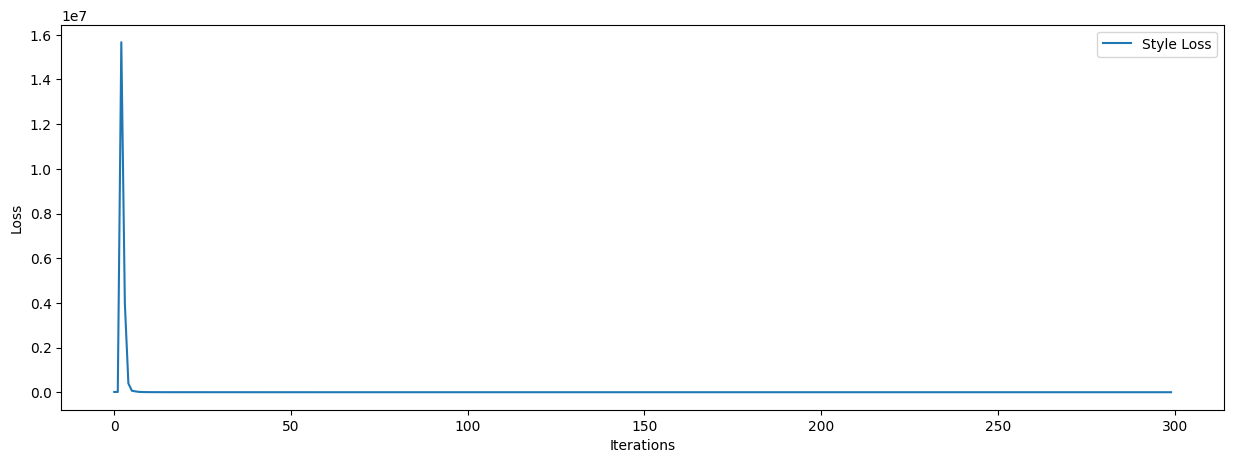

In [ ]:
# TODO: Plot the style loss w.r.t. the iteration number

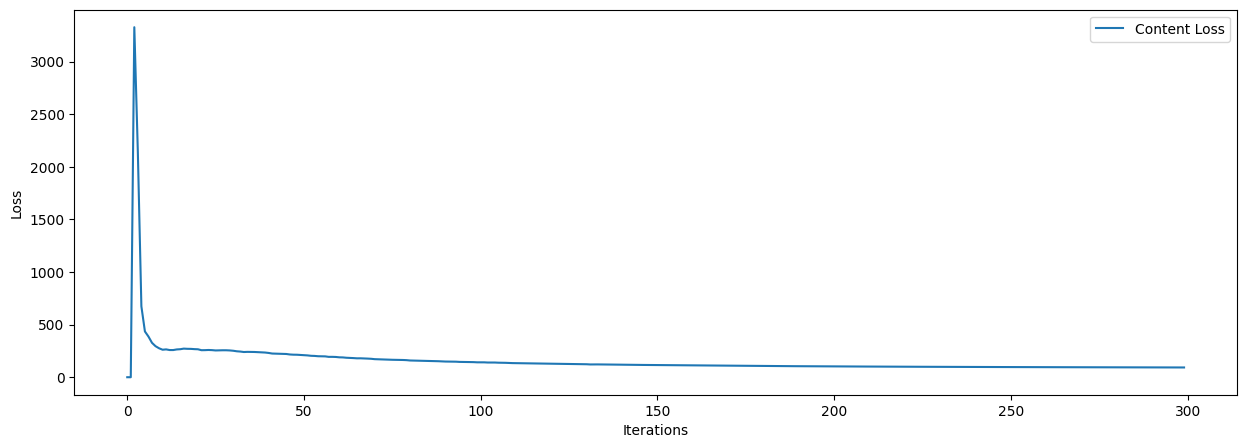

In [ ]:
# TODO: Plot the content loss w.r.t. the iteration number